# Facies Classification Based on SEG Tutorial (2016)

#### T. Altay Sansal

Here I am using the open data under the SEG 2016 facies classification tutorial which can be found [here](https://github.com/seg/tutorials-2016/blob/master/1610_Facies_classification/).

There are 9 different facies there were classified using core analysis. They are labeled and numbered as following.

 1. Nonmarine sandstone: <b>SS</b>
 2. Nonmarine coarse siltstone: <b>CSiS</b>
 3. Nonmarine fine siltstone: <b>FSiS</b>
 4. Marine siltstone and shale: <b>SiSh</b>
 5. Mudstone (limestone): <b>MS</b>
 6. Wackestone (limestone): <b>WS</b>
 7. Dolomite: <b>D</b>
 8. Packstone-grainstone (limestone): <b>PS</b>
 9. Phylloid-algal bafflestone (limestone): <b>BS</b>

Let's import some functions we are using.

In [1]:
from os.path import join

from numpy import arange
from pandas import read_csv, options, set_option

from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler

from matplotlib.pyplot import close, subplots
from matplotlib import rcParams
import seaborn as sns

from globals import FACIES_LABELS, FACIES_COLORS
from visualization import make_facies_log_plot

# Set display parameters for pandas and matplotlib
set_option("display.max_rows", 10)
options.mode.chained_assignment = None
%matplotlib inline

print("Imported all functions successfully!")

Imported all functions successfully!


Now that we have the library functions we need, we can start reading and exploring the data.

For reading and organizing, I will be using Pandas. After reading, it will show example data and statistics.

In [2]:
file_path = join('data_input', 'facies_vectors.csv')

well_data = read_csv(file_path)
well_data.set_index('Well Name', inplace=True)

all_wells = well_data.index.unique()

# List names of files
print("There are %s wells in *.csv file:" % len(all_wells))
for well_name in all_wells:
    print("  - %s" % well_name)

# Add actual test labels to dataframe
well_data.loc[:,'FaciesLabels'] = well_data.apply(lambda row: FACIES_LABELS[(row['Facies'])], axis=1)

well_data

There are 10 wells in *.csv file:
  - SHRIMPLIN
  - ALEXANDER D
  - SHANKLE
  - LUKE G U
  - KIMZEY A
  - CROSS H CATTLE
  - NOLAN
  - Recruit F9
  - NEWBY
  - CHURCHMAN BIBLE


,Facies,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
Well Name,,,,,,,,,,,
SHRIMPLIN,3,A1 SH,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
SHRIMPLIN,3,A1 SH,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
SHRIMPLIN,3,A1 SH,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
SHRIMPLIN,3,A1 SH,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
SHRIMPLIN,3,A1 SH,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...
CHURCHMAN BIBLE,5,C LM,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
CHURCHMAN BIBLE,5,C LM,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
CHURCHMAN BIBLE,5,C LM,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS


And to show stats:

In [3]:
well_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Now that I have access to the data, I will exclude one well for blind tests. I will also plot the blind well.

Note that all features have 4149 data points with the exception of PE. 

Rest of the wells will be used for training the model.

Training will be done with 9 wells:
  - SHRIMPLIN
  - ALEXANDER D
  - LUKE G U
  - KIMZEY A
  - CROSS H CATTLE
  - NOLAN
  - Recruit F9
  - NEWBY
  - CHURCHMAN BIBLE


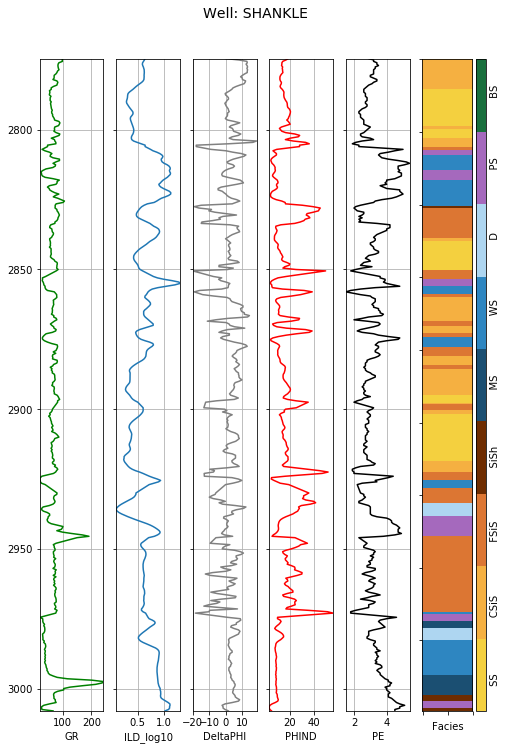

In [4]:
blind_well = well_data.loc['SHANKLE']
make_facies_log_plot(blind_well, FACIES_COLORS)
training_data = well_data.drop('SHANKLE')
training_wells = training_data.index.unique()

print("Training will be done with %s wells:" % len(training_wells))
for well_name in training_wells:
    print("  - %s" % well_name)

SS      179
CSiS    851
FSiS    663
SiSh    264
MS      277
WS      511
D       124
PS      646
BS      185
Name: Facies, dtype: int64

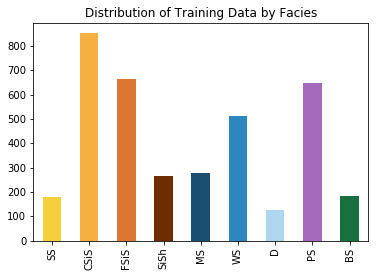

In [5]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = FACIES_LABELS.values()

fig = facies_counts.plot(kind='bar',color=FACIES_COLORS, 
                   title='Distribution of Training Data by Facies')

facies_counts

Training data has NaN values. We can quickly fix that by filling gaps with the mean. Not ideal, but will work.

In [6]:
PE_vals = training_data[['GR', 'PE']]

# Fill missing PE values with mean
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer.fit(PE_vals)
PE_vals = imputer.transform(PE_vals)

# Put it back to dataframe
training_data['PE'] = PE_vals[:, 1]

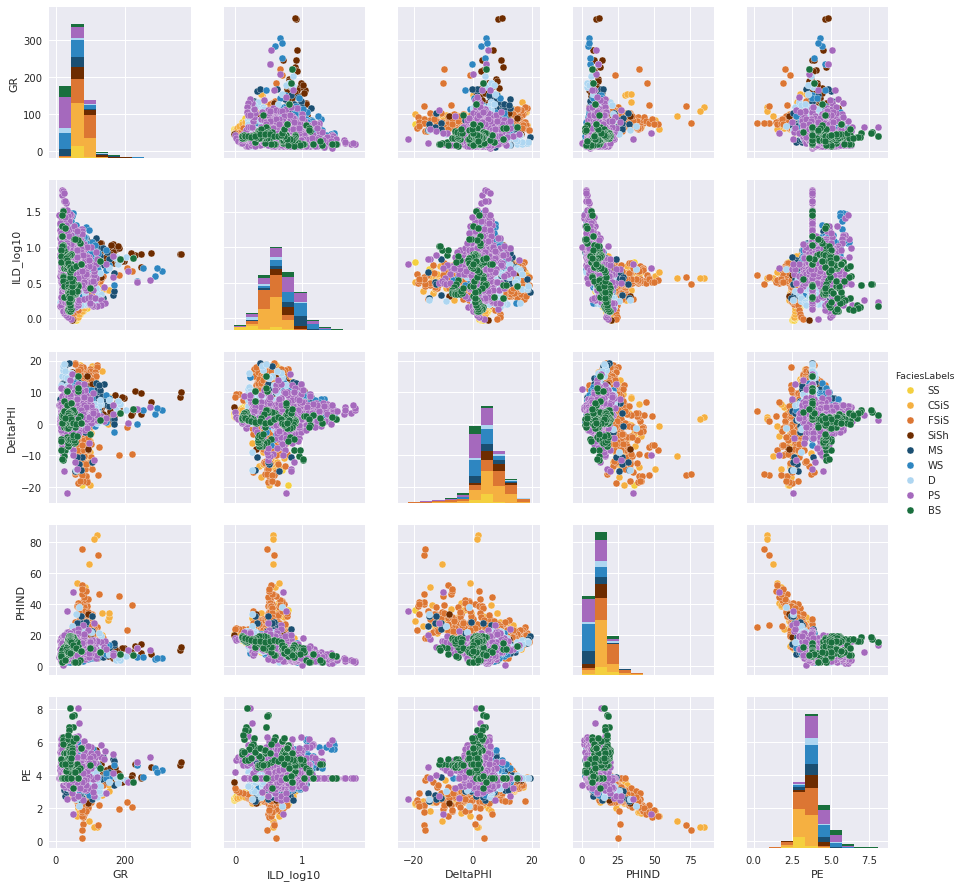

In [7]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(rcParams)

sns.set()
sns.pairplot(training_data.drop(labels=['Facies','Formation','Depth','NM_M','RELPOS'], axis=1),
             hue='FaciesLabels', palette=FACIES_COLORS,
             hue_order=list(FACIES_LABELS.values()))

#switch back to default matplotlib plot style
rcParams.update(inline_rc)

In [10]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Depth','Facies','FaciesLabels'], axis=1)

scaler = StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

# GPC
kernel = 1.0 * RBF([1.0]*7)
clf = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

# # SVM
# clf = svm.SVC()

clf.fit(X_train,y_train)
predicted_labels = clf.predict(X_test)

conf = confusion_matrix(y_test, predicted_labels)

def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

print('Facies classification accuracy = %f' % accuracy(conf))
conf

Facies classification accuracy = 0.679730


array([[ 22,  20,   2,   0,   0,   0,   0,   0,   0],
       [  0, 149,  27,   1,   0,   0,   0,   0,   0],
       [  0,  37,  92,   0,   1,   1,   0,   1,   0],
       [  0,   0,   1,  53,   1,   6,   0,   3,   0],
       [  0,   1,   0,   7,  18,  11,   0,   8,   0],
       [  0,   0,   0,  13,   5,  46,   3,  25,   5],
       [  0,   0,   0,   1,   4,   2,   2,  12,   7],
       [  0,   0,   1,   3,   5,  17,   0,  91,   1],
       [  0,   0,   0,   0,   0,   0,   0,   5,  30]])

In [11]:
print(y_test)
print(predicted_labels)
f1_score(y_test, predicted_labels, average='micro')

[4 2 3 8 2 3 5 8 4 6 2 7 3 6 4 2 6 8 2 3 3 3 4 4 8 3 2 6 4 2 4 8 2 8 8 2 8
 2 4 3 2 6 3 4 1 2 2 2 2 1 6 6 2 9 9 2 8 7 3 2 2 2 2 5 6 2 8 2 5 2 6 3 4 2
 2 2 8 2 6 3 4 2 6 7 4 8 5 1 2 8 5 8 3 4 5 4 9 4 3 6 3 2 7 6 8 4 8 2 8 3 8
 3 4 8 6 2 3 3 9 4 3 2 2 2 5 6 2 6 2 7 4 8 4 1 3 2 1 2 2 8 8 5 2 1 3 8 8 6
 8 2 3 3 8 2 2 3 2 7 4 6 8 3 1 3 6 8 6 6 3 8 2 6 2 6 6 7 4 5 6 2 1 7 3 3 2
 2 3 3 2 5 1 2 3 2 9 8 8 2 3 2 4 2 8 3 4 6 6 3 9 2 2 8 4 5 8 9 3 5 8 3 4 2
 2 9 2 6 2 9 6 6 9 6 4 1 8 4 2 2 2 2 1 3 6 8 4 2 3 3 3 8 1 1 8 5 5 2 8 2 2
 3 2 8 9 5 9 3 2 9 6 7 6 3 6 4 8 6 5 9 8 8 2 4 3 1 1 5 3 3 8 4 6 3 1 2 6 2
 9 1 5 6 9 9 1 6 2 5 8 8 2 3 4 5 1 2 4 1 6 9 2 3 6 8 8 4 2 3 2 2 2 8 2 6 2
 2 2 6 8 8 4 2 2 8 3 3 2 7 8 6 6 6 3 1 6 3 2 6 8 6 6 8 5 1 1 8 3 3 8 6 2 3
 8 2 5 2 8 5 1 9 5 5 1 2 3 2 1 9 1 8 3 2 2 3 1 2 3 6 7 8 2 2 8 2 4 8 3 2 3
 2 5 8 7 2 8 2 2 3 5 4 9 9 3 2 3 6 3 8 8 9 6 6 2 5 2 5 8 1 3 2 4 9 3 4 3 2
 2 2 2 6 8 2 3 8 4 8 2 2 2 4 2 8 8 8 6 6 3 9 4 6 3 6 8 8 6 3 2 2 8 6 7 6 1
 2 2 6 8 3 2 3 3 1 2 9 3 

0.67972972972972978